In [183]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from  tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dropout

In [184]:
# Load the dataset
path='E:/Job/ventas_ANDI_Complete_Hist_Just_Montura.xlsx'
store_sales=pd.read_excel(path, sheet_name='ventas20190101-20231231')
store_sales.dropna(subset=['Tot_Bill'],inplace=True)
store_sales['Date'] = pd.to_datetime(store_sales['Date'])
filter2 = store_sales['marca'] == "CD" #monturas 
store_sales['Date'] = store_sales['Date'].dt.year.astype('str') + '-' + store_sales['Date'].dt.month.astype('str') + '-01'
store_sales['Date'] = pd.to_datetime(store_sales['Date'])
store_sales.where(filter2, inplace=True)
store_sales = store_sales.groupby(['Date','marca']).Tot_Bill.sum().reset_index()
store_sales.set_index('Date')
store_sales['sales_diff'] = store_sales['Tot_Bill'].diff()
store_sales.dropna(inplace=True)
store_sales


,Date,marca,Tot_Bill,sales_diff
1,2019-12-01,CD,52421800.0,9871700.0
2,2020-01-01,CD,23383900.0,-29037900.0
3,2020-02-01,CD,15132790.0,-8251110.0
4,2020-03-01,CD,9847990.0,-5284800.0
5,2020-06-01,CD,13809770.0,3961780.0
6,2020-07-01,CD,16123140.0,2313370.0
7,2020-08-01,CD,44257792.0,28134652.0
8,2020-09-01,CD,32907770.0,-11350022.0
9,2020-10-01,CD,23774414.0,-9133356.0
10,2020-11-01,CD,36374440.0,12600026.0


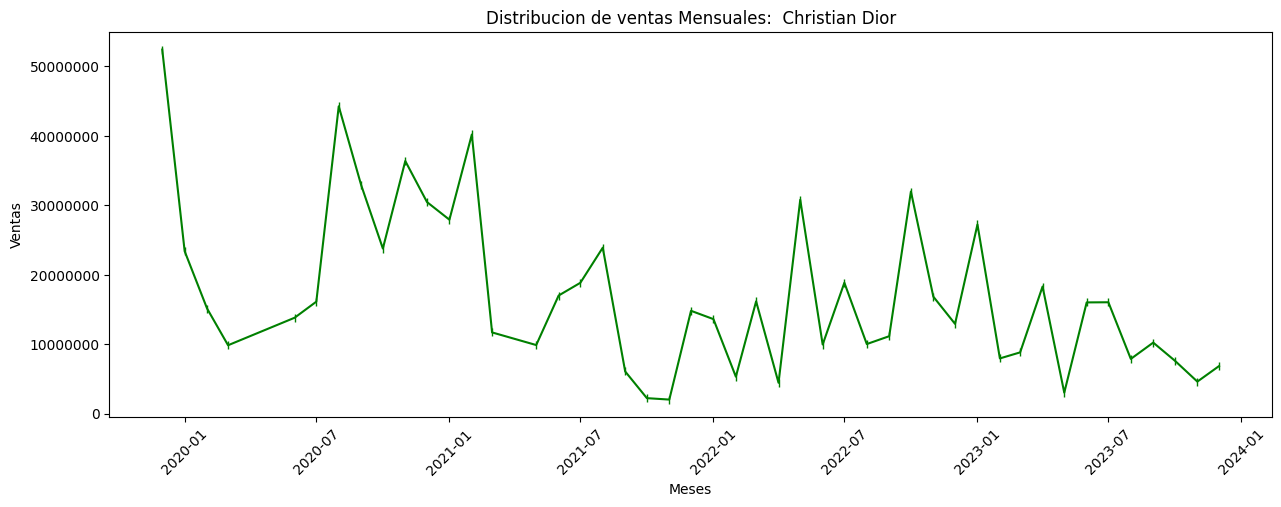

In [185]:

plt.figure(figsize=(15,5))
plt.plot(store_sales['Date'], store_sales['Tot_Bill'],marker='|',linestyle='-',color='green')
plt.title('Distribucion de ventas Mensuales:  Christian Dior')
plt.xlabel('Meses')
plt.ylabel('Ventas')
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=45)
plt.grid=True
plt.show()


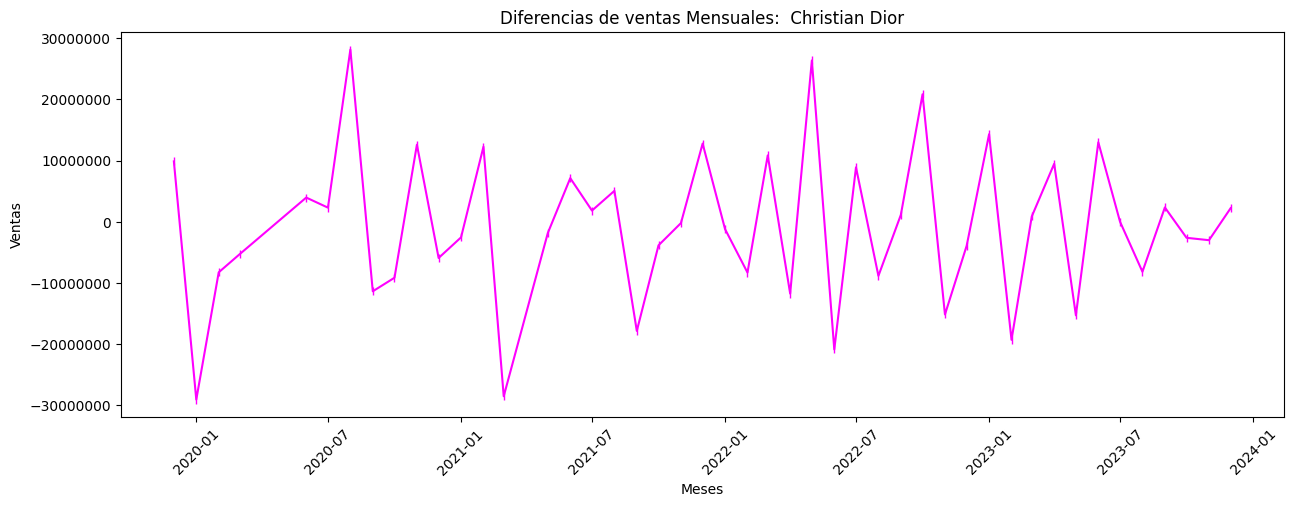

In [186]:
plt.figure(figsize=(15,5))
plt.plot(store_sales['Date'], store_sales['sales_diff'],marker='|',linestyle='-',color='magenta')
plt.title('Diferencias de ventas Mensuales:  Christian Dior')
plt.xlabel('Meses')
plt.ylabel('Ventas')
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=45)
plt.grid=True
plt.show()

In [187]:
supervised_data = store_sales.drop(['marca','Date','Tot_Bill'],axis=1)
supervised_data.count()

sales_diff    46
dtype: int64

In [188]:
for i  in range(1,13):
    col_name='month_'+ str(i)
    supervised_data[col_name] = supervised_data['sales_diff'].shift(i)
supervised_data = supervised_data.dropna().reset_index(drop=True)
supervised_data.size
supervised_data

,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,12269261.0,-2540919.0,-5907686.0,12600026.0,-9133356.0,-11350022.0,28134652.0,2313370.0,3961780.0,-5284800.0,-8251110.0,-29037900.0,9871700.0
1,-28499896.0,12269261.0,-2540919.0,-5907686.0,12600026.0,-9133356.0,-11350022.0,28134652.0,2313370.0,3961780.0,-5284800.0,-8251110.0,-29037900.0
2,-1819280.0,-28499896.0,12269261.0,-2540919.0,-5907686.0,12600026.0,-9133356.0,-11350022.0,28134652.0,2313370.0,3961780.0,-5284800.0,-8251110.0
3,7130912.0,-1819280.0,-28499896.0,12269261.0,-2540919.0,-5907686.0,12600026.0,-9133356.0,-11350022.0,28134652.0,2313370.0,3961780.0,-5284800.0
4,1833752.0,7130912.0,-1819280.0,-28499896.0,12269261.0,-2540919.0,-5907686.0,12600026.0,-9133356.0,-11350022.0,28134652.0,2313370.0,3961780.0
5,5058106.0,1833752.0,7130912.0,-1819280.0,-28499896.0,12269261.0,-2540919.0,-5907686.0,12600026.0,-9133356.0,-11350022.0,28134652.0,2313370.0
6,-17826698.0,5058106.0,1833752.0,7130912.0,-1819280.0,-28499896.0,12269261.0,-2540919.0,-5907686.0,12600026.0,-9133356.0,-11350022.0,28134652.0
7,-3841992.0,-17826698.0,5058106.0,1833752.0,7130912.0,-1819280.0,-28499896.0,12269261.0,-2540919.0,-5907686.0,12600026.0,-9133356.0,-11350022.0
8,-204775.0,-3841992.0,-17826698.0,5058106.0,1833752.0,7130912.0,-1819280.0,-28499896.0,12269261.0,-2540919.0,-5907686.0,12600026.0,-9133356.0
9,12781563.0,-204775.0,-3841992.0,-17826698.0,5058106.0,1833752.0,7130912.0,-1819280.0,-28499896.0,12269261.0,-2540919.0,-5907686.0,12600026.0


In [189]:
train_data = supervised_data[:-12] # no tome el ultimo año para de data
test_data = supervised_data[-18:] # realice pruebas con la data del ultimo año
print("train data shape", train_data.shape) # el tamaño es una matriz de 22 filas X 13 columnas:  que son los meses mas la COL de diferencias
print("test data shape", test_data.shape) # el tamaño es una matrix de 12 filas X 13 columnas: que son los meses mas la COL de diferencias

train data shape (22, 13)
test data shape (18, 13)


In [190]:
scaler = MinMaxScaler(feature_range=(-1,1)) # dejar la data con valores entre -1 y 1 para que la media sea cero
scaler.fit(train_data) #  con la data de entrenamiento , Calcula el mínimo y el máximo que se utilizará para el escalamiento posterior.
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)
X_train, y_train = train_data[:,1:], train_data[:,0:1]
X_test, y_test = test_data[:,1:], test_data[:,0:1]
y_train=y_train.ravel()
y_test=y_test.ravel()

In [191]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (22, 12)
y_train shape: (22,)
X_test shape: (18, 12)
y_test shape: (18,)


In [192]:
sales_dates = store_sales['Date'][-12:].reset_index(drop=True)# tiene los ultimos 12 meses 
predict_df = pd.DataFrame(sales_dates)

In [193]:
act_sales=store_sales['Tot_Bill'][-18:].to_list() # en act_sales esta el total de las ventas X mes de la marca CD
print(act_sales)

[18848360.0, 10019560.0, 11150020.0, 31983420.0, 16843186.0, 12927400.0, 27235164.0, 7951600.0, 8821820.0, 18302480.0, 3023440.0, 16016180.0, 16037020.0, 7880680.0, 10228440.0, 7614800.0, 4612100.0, 6851680.0]


In [194]:
#linear regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pre=lr_model.predict(X_test)

In [195]:
lr_pre = lr_pre.reshape(-1,1)
lr_pre_test_set = np.concatenate([lr_pre,X_test],axis=1)
lr_pre_test_set = scaler.inverse_transform(lr_pre_test_set)

In [196]:
result_list=[]
for index in range(0,len(lr_pre_test_set)):
    result_list.append(lr_pre_test_set[index][0]+act_sales[index])
lr_pre_series = pd.Series(result_list,name='linear Prediction')
predict_df=predict_df.merge(lr_pre_series,left_index=True,right_index=True)


In [197]:
print(predict_df)

         Date  linear Prediction
0  2023-01-01       2.364878e+07
1  2023-02-01       1.336865e+06
2  2023-03-01       1.161935e+07
3  2023-04-01       4.378978e+07
4  2023-05-01      -4.497526e+06
5  2023-06-01       1.759804e+07
6  2023-07-01       1.868164e+07
7  2023-08-01      -4.250112e+06
8  2023-09-01       3.387576e+07
9  2023-10-01       1.921707e+07
10 2023-11-01      -1.081537e+07
11 2023-12-01       2.372719e+07


In [198]:
lr_mse = np.sqrt(mean_squared_error(predict_df['linear Prediction'],store_sales['Tot_Bill'][-12:]))
lr_mae = mean_absolute_error(predict_df['linear Prediction'],store_sales['Tot_Bill'][-12:])
lr_r2 = r2_score (predict_df['linear Prediction'],store_sales['Tot_Bill'][-12:])

print("Lenear regression MSE:", lr_mse )
print("Lenear regression MAE:", lr_mae )
print("Lenear regression R2:", lr_r2)
#print(predict_df)


Lenear regression MSE: 13366191.987414127
Lenear regression MAE: 10826396.77528186
Lenear regression R2: 0.2821238254894668


In [199]:
print(X_train.shape)
print(train_data.shape)

(22, 12)
(22, 13)


[]

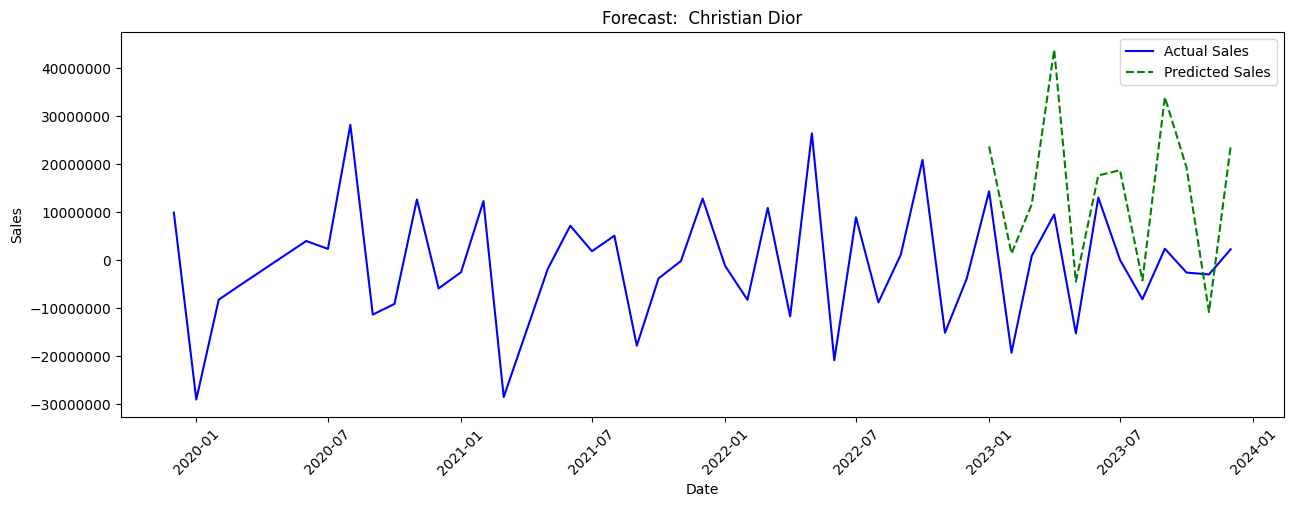

In [200]:
plt.figure(figsize=(15,5))
ax = plt.gca()
plt.plot(store_sales['Date'], store_sales['sales_diff'],linestyle='-',color='blue')
plt.plot(predict_df['Date'], predict_df['linear Prediction'],linestyle='--',color='green')
plt.title("Forecast:  Christian Dior")
plt.xlabel('Date')
plt.ylabel('Sales')
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=45)
plt.legend(["Actual Sales","Predicted Sales"])
plt.plot()


In [201]:
model = Sequential()
model.add(LSTM(90, activation='relu', return_sequences=True, input_shape=(12,1)))
model.add(LSTM(90, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
#train_data.shape
#fit_lstm(train_data,1,100,4)

C:\Users\User\anaconda3\envs\Learning\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [202]:
#X_train, y_train = train_data[:,1:], train_data[:,0:1]
#X_test, y_test = test_data[:,1:], test_data[:,0:1]
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (22, 12)
y_train shape: (22,)
X_test shape: (18, 12)
y_test shape: (18,)


In [203]:
Bhistory = model.fit(X_train, y_train, batch_size=4, epochs=150, validation_data=(X_test, y_test), verbose=1)

Epoch 1/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.2811 - val_loss: 0.1480
Epoch 2/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2236 - val_loss: 0.1482
Epoch 3/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1997 - val_loss: 0.1480
Epoch 4/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3589 - val_loss: 0.1480
Epoch 5/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2909 - val_loss: 0.1479
Epoch 6/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2168 - val_loss: 0.1478
Epoch 7/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2160 - val_loss: 0.1478
Epoch 8/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2445 - val_loss: 0.1478
Epoch 9/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2564 - val_loss: 0.1480
Epoch 10/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3180 - val_loss: 0.1478
Epoch 11/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2060 - val_loss: 0.1477
Epoch 12/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2204 - val_loss: 0.147

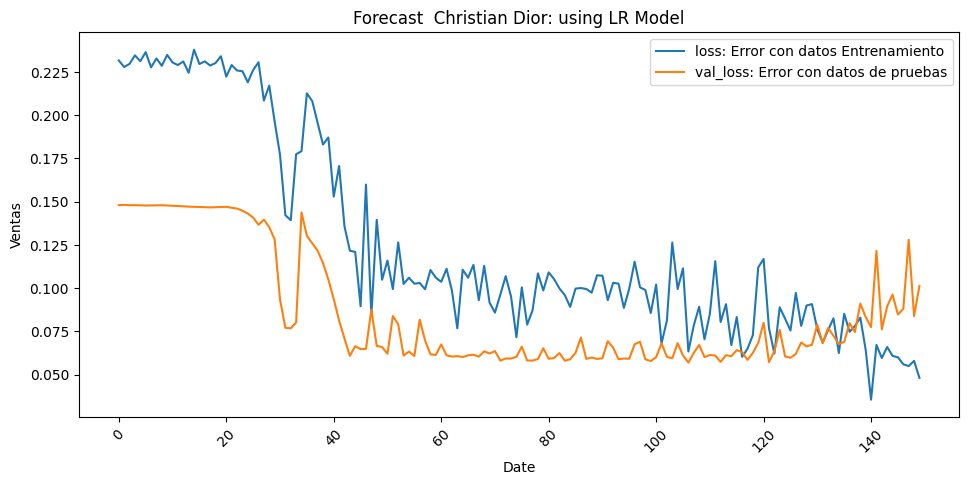

In [204]:
fig = plt.figure(figsize=(25,5))
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(Bhistory.history['loss'], label='loss: Error con datos Entrenamiento')
ax1.plot(Bhistory.history['val_loss'], label='val_loss: Error con datos de pruebas')
plt.title('Forecast  Christian Dior: using LR Model')
plt.xlabel('Date')
plt.ylabel('Ventas')
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=45)
ax1.legend()
plt.show()

In [216]:
#SIZE = data.shape[0]
#TRAIN_SPLIT = round(SIZE * 0.7)=y_test 
#uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
act_sales=store_sales['Tot_Bill'][-18:].to_list() # en act_sales esta el total de las ventas X mes de la marca CD
#print(act_sales)

predicted = model.predict(X_test)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [217]:
predicted = predicted.reshape(-1,1)
lpre_test_set = np.concatenate([predicted,X_test],axis=1)
lpre_test_set = scaler.inverse_transform(lpre_test_set)



In [212]:
predict_df2 = pd.DataFrame(sales_dates)
result_list2=[]
for index in range(0,len(lpre_test_set)):
    result_list2.append(lpre_test_set[index][0]+act_sales[index])
lpre_series = pd.Series(result_list2,name='linear Prediction')

predict_df2=predict_df2.merge(lpre_series,left_index=True,right_index=True)

In [218]:
predict_df2

,Date,linear Prediction
0,2023-01-01,2.157158e+07
1,2023-02-01,2.680420e+06
2,2023-03-01,1.522129e+07
3,2023-04-01,4.190015e+07
4,2023-05-01,1.549560e+06
5,2023-06-01,1.236919e+07
6,2023-07-01,3.424200e+07
7,2023-08-01,-3.304142e+06
8,2023-09-01,9.217175e+06
9,2023-10-01,2.541293e+07


In [210]:
X_test.shape

(18, 12)

[]

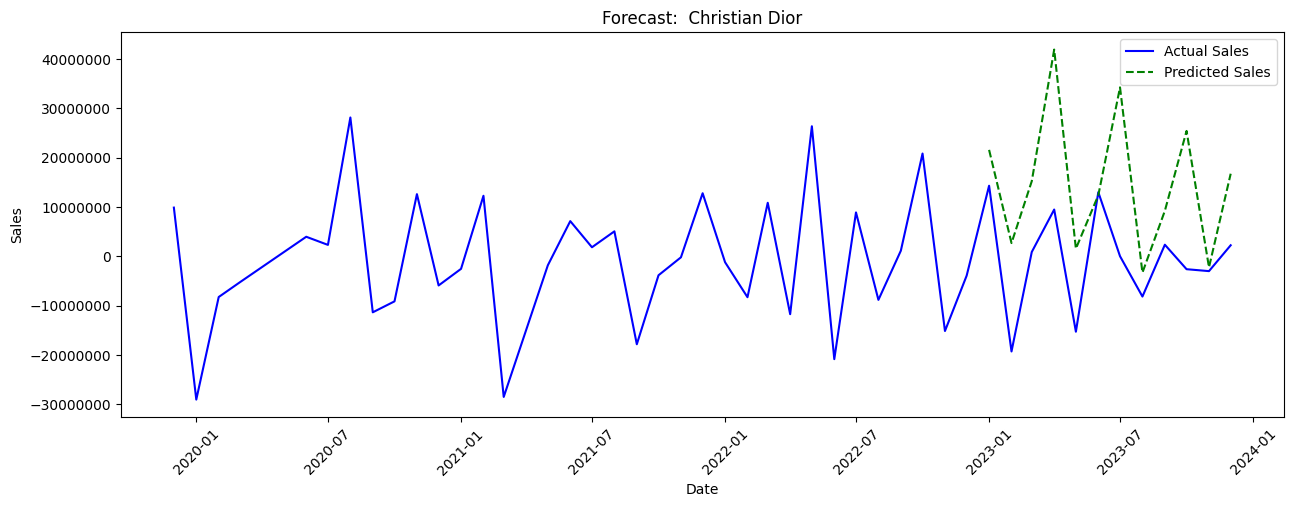

In [214]:

plt.figure(figsize=(15,5))
ax = plt.gca()
plt.plot(store_sales['Date'], store_sales['sales_diff'],linestyle='-',color='blue')
plt.plot(predict_df2['Date'], predict_df2['linear Prediction'],linestyle='--',color='green')
plt.title("Forecast:  Christian Dior")
plt.xlabel('Date')
plt.ylabel('Sales')
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=45)
plt.legend(["Actual Sales","Predicted Sales"])
plt.plot()